For the last two questions regarding what are related to relationships of variables with salary and job satisfaction - Each of these questions will involve not only building some sort of predictive model, but also finding and interpretting the influential components of whatever model we build.

To get started let's read in the necessary libraries and take a look at some of our columns of interest.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df_schema = pd.read_csv('./survey_results_schema.csv')
df = pd.read_csv('./survey_results_public.csv', low_memory = False)
df.head()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


# Change some columns from categorical to numeric


In [19]:
# replace age years with integer
df['Age'] = df['Age'].apply(lambda x: {
    'Under 18 years old': 18,
    '65 years or older': 65,
    '55 - 64 years old': 60,
    '45 - 54 years old': 50,
    '35 - 44 years old': 40,
    '25 - 34 years old': 30,
    '18 - 24 years old': 20,
    np.NaN: np.NaN
}[x])

# replace converted Salary to integer
df['ConvertedSalary'] = df[['ConvertedSalary']].apply(pd.to_numeric, errors="coerce")

# Get data for the two age groups to study

In [20]:
df40 = df_age[df_age.Age == 40].drop(columns=["Age"])
df30 = df_age[df_age.Age == 30].drop(columns=["Age"])

# Basic function Handling Multiple Choice Questions

In [24]:
def demultiplechoice(value_counts, norm = True):
    '''
    INPUT
    value_counts - result of .value_counts for a Series
    norm - normalize output to sum to 1
    
    OUTPUT
    - Sorted list of (value, X) items ready to be passed to a dict function.
      X is the count if norm is False or the percentage of the value if norm
      is True
    
    This function gets value_counts where multiple values are separated by ';' 
    and returns value counts for each choice
    '''
    values = {}
    total = 0
    for i, combo_value in enumerate(value_counts.index):
        vals = str(combo_value).split(';')
        for val in vals:
            values[val] = values.get(val, 0) + value_counts.values[i]
            total += value_counts.values[i]
    return [(j[1], j[0] / total if norm else j[0]) for j in sorted([(i[1], i[0]) for i in values.items()])]

In [46]:
def countmultiplechoice(value_counts):
    '''
    INPUT
    value_counts - result of .value_counts for a Series
    
    OUTPUT
    - Sorted list of (X, Y) items ready to be passed to a dict function.
      X is the count of values in each row and Y is the count of rows for 
      this number of concurently selected options
    
    This function gets value_counts where multiple values are separated by ';' 
    and returns counts for each number of choices in an answer
    '''
    values = {}
    total = 0
    for i, combo_value in enumerate(value_counts.index):
        vals = str(combo_value).split(';')
        val = len(vals)
        values[val] = values.get(val, 0) + value_counts.values[i]
        total += value_counts.values[i]
    return [(j[1], j[0]) for j in sorted([(i[1], i[0]) for i in values.items()])]

# Explore fields of difference between the two age groups

Initially crossentropy of the two distributions and then exploratory diagram plotting

In [31]:
def cross_entropy(s1, s2):
    '''
    INPUT
    s1 - Series 1
    s2 - Series 2
    
    OUTPUT
    - crossentropy of s1 and s2
    
    This function calculates the cross entropy of two series
    '''
    dfsum1 = dict(demultiplechoice(s1.value_counts()))
    dfsum2 = dict(demultiplechoice(s2.value_counts()))  
    return -sum([dfsum1.get(value,0) * np.log(dfsum2.get(value, 0)) for value in dfsum1 ])

In [33]:
# a list to keep (and sort results)
res = []

# for each categorical column calculate cross-entropy
catcols = df40.select_dtypes(include=['object']).columns
for column in catcols:
    res.append((cross_entropy(df30[column], df40[column]), column))    
    
# sort
res.sort()

# print top 20
for ce, column in res[-20:]:
    print(ce, column)

C:\Users\aagis\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: divide by zero encountered in log


1.9653216016011126 SelfTaughtTypes
2.0080743216505255 EducationTypes
2.0815644372338533 StackOverflowJobsRecommend
2.1411746132987237 FrameworkWorkedWith
2.1731617998746016 Currency
2.19496302388288 CommunicationTools
2.282316824228903 FrameworkDesireNextYear
2.4551825363693944 YearsCodingProf
2.5626307051669928 DevType
2.579156633889685 DatabaseWorkedWith
2.6534111490033103 IDE
2.6612868918627672 YearsCoding
2.755132435730585 PlatformWorkedWith
2.7900813782573497 DatabaseDesireNextYear
2.879855446041771 PlatformDesireNextYear
2.9434563255530706 LanguageWorkedWith
3.1113691955422786 LanguageDesireNextYear
inf Country
inf CurrencySymbol
inf Salary


YearsCodingProf


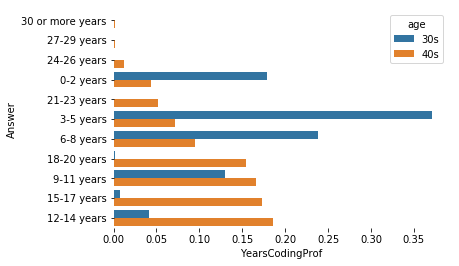

HopeFiveYears


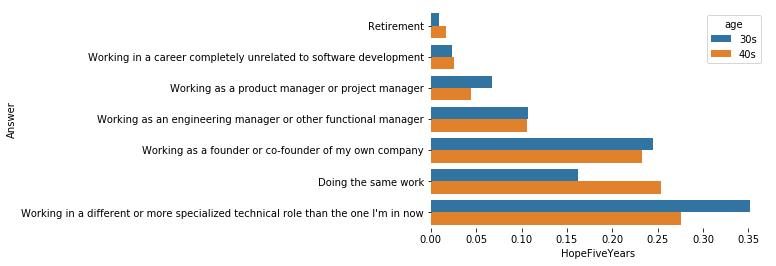

JobSatisfaction


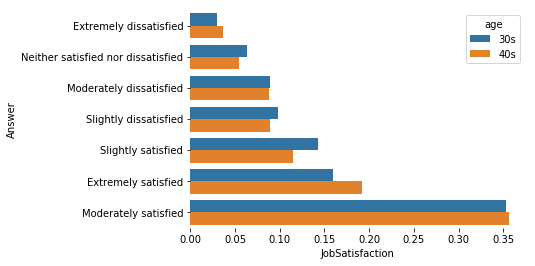

Student


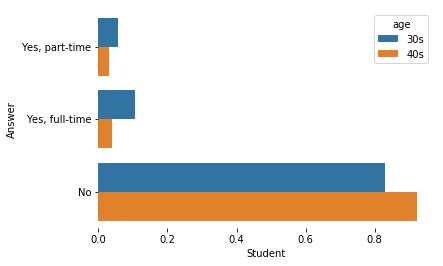

LastNewJob


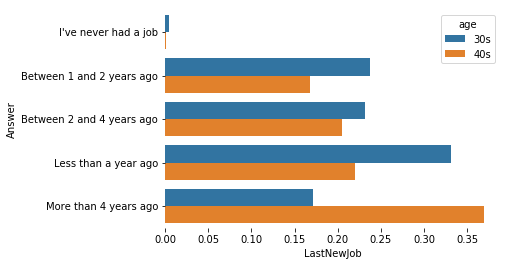

OpenSource


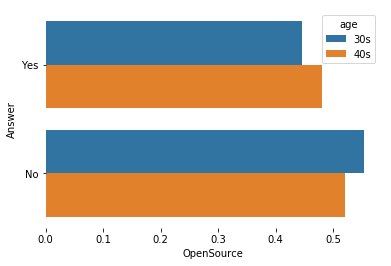

HackathonReasons


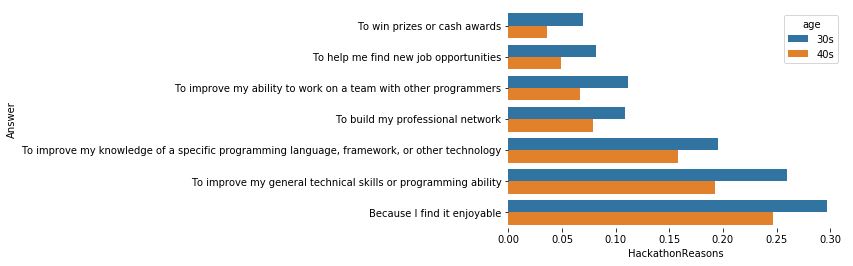

UpdateCV


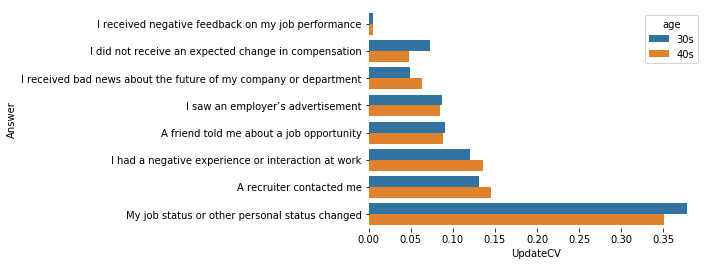

Country


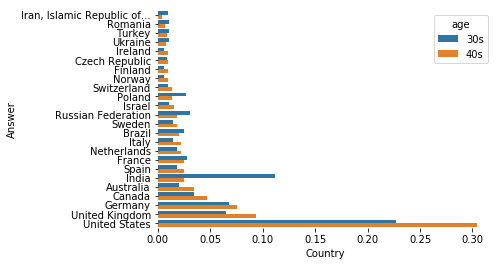

Methodology


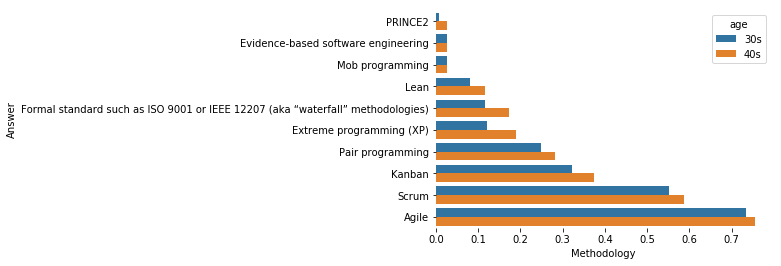

CommunicationTools


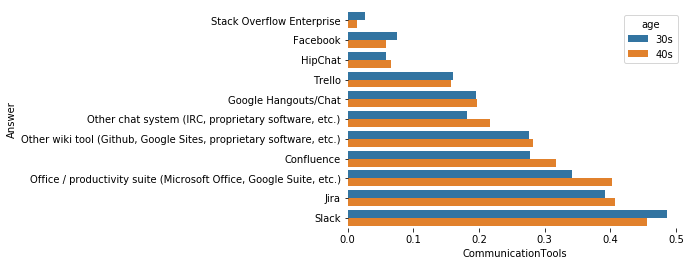

LanguageDesireNextYear


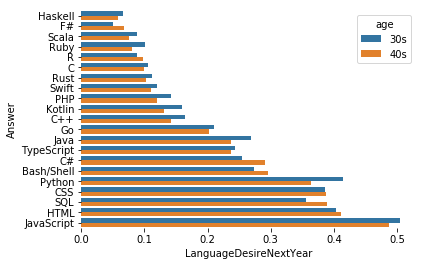

LanguageWorkedWith


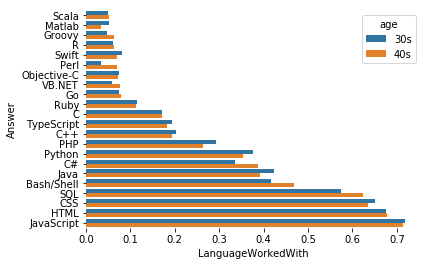

IDE


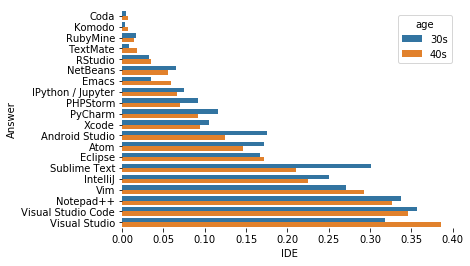

DevType


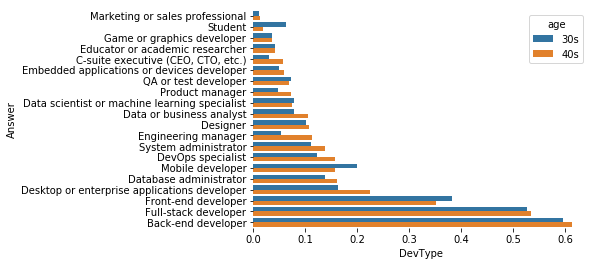

SelfTaughtTypes


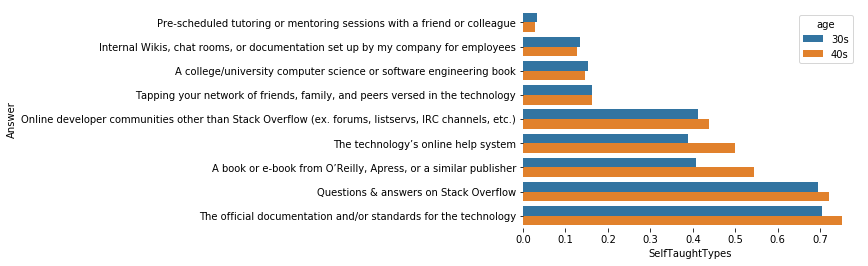

EducationTypes


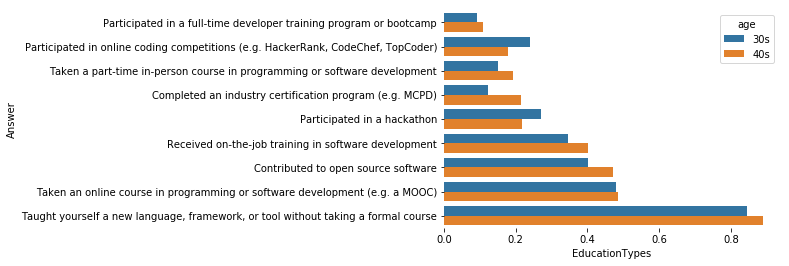

TimeAfterBootcamp


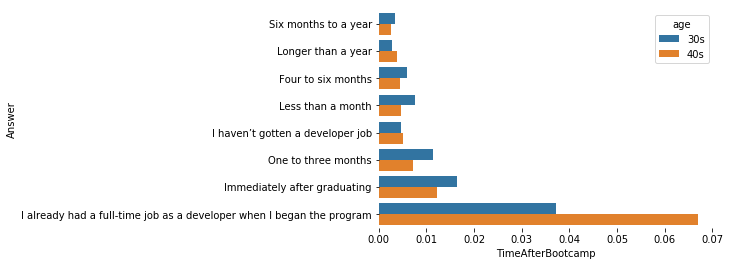

ConvertedSalary


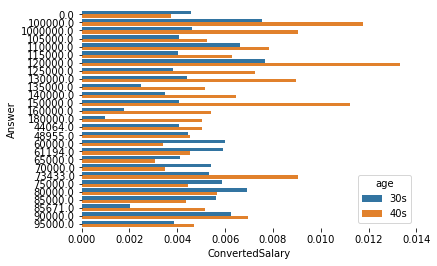

CompanySize


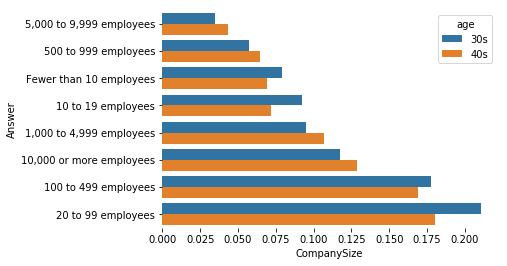

In [53]:
for column in ['YearsCodingProf', 'HopeFiveYears', 'JobSatisfaction', 'Student', 
               'LastNewJob', 'OpenSource', 'HackathonReasons', 'UpdateCV', 
               'Country', 'Methodology', 'CommunicationTools', 'LanguageDesireNextYear', 
               'LanguageWorkedWith', 'IDE', 'DevType', 'SelfTaughtTypes', 'EducationTypes',
               'TimeAfterBootcamp', 'ConvertedSalary', 'CompanySize']:
    print(column)
    
    # get values
    dfsum1 = df30[column].value_counts() / df30.shape[0]
    dfsum2 = df40[column].value_counts() / df40.shape[0]
    values1 = demultiplechoice(dfsum1, norm = False)
    values2 = demultiplechoice(dfsum2, norm = False)
    
    # get keys
    keys = [i[0] for i in values2[-20:]]
    keys = [i[0] for i in values1[-20:] if i[0] not in keys] + keys
    if column in ['ConvertedSalary']:
        keys = [i[1] for i in sorted([(float(k),k) for k in keys])]
    d1 = dict(values1)
    d2 = dict(values2)
    
    # make dataframe
    values = []
    values += [('30s', key, d1.get(key,0)) for key in keys]
    values += [('40s', key, d2.get(key,0)) for key in keys]
    sdf = pd.DataFrame(columns = ['age', 'Answer', column], data = values)
    
    #plot
    sns.barplot(x = column, y = 'Answer', hue='age', data=sdf, orient="h")
    sns.despine(left=True, bottom=True)
    plt.show()


LanguageWorkedWith
30s mean: 5.11974558392899
40s mean: 5.126513897359991


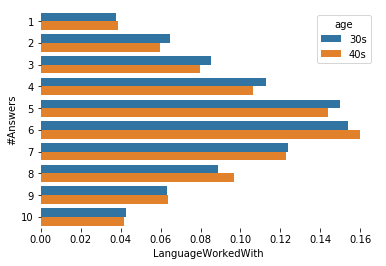

SelfTaughtTypes
30s mean: 3.0924147485752065
40s mean: 3.41665940576806


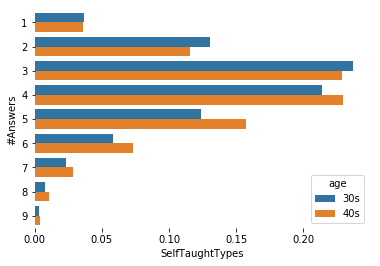

In [54]:
for column in ['LanguageWorkedWith', 'SelfTaughtTypes']:
    print (column)
    
    # get values
    dfsum1 = df30[column].value_counts() / df30.shape[0]
    dfsum2 = df40[column].value_counts() / df40.shape[0]
    values1 = countmultiplechoice(dfsum1)
    values2 = countmultiplechoice(dfsum2)
    
    # get keys
    keys = [i[0] for i in values2[-10:]]
    keys = [i[0] for i in values1[-10:] if i[0] not in keys] + keys
    if column in ['ConvertedSalary']:
        keys = [i[1] for i in sorted([(float(k),k) for k in keys])]
    d1 = dict(values1)
    d2 = dict(values2)

    # make dataframe
    values = []
    values += [('30s', key, d1.get(key,0)) for key in keys]
    values += [('40s', key, d2.get(key,0)) for key in keys]
    sdf = pd.DataFrame(columns = ['age', '#Answers', column], data = values)
    
    # print averages
    print('30s mean:', (sdf[sdf['age'] == '30s'][column] * sdf[sdf['age'] == '30s']['#Answers']).sum())
    print('40s mean:', (sdf[sdf['age'] == '40s'][column] * sdf[sdf['age'] == '40s']['#Answers']).sum())
    
    #plot
    sns.barplot(x = column, y = '#Answers', hue='age', data=sdf, orient="h")
    sns.despine(left=True, bottom=True)
    plt.show()

# Suggesting Career changes by job satisfaction and salary


HopeFiveYears


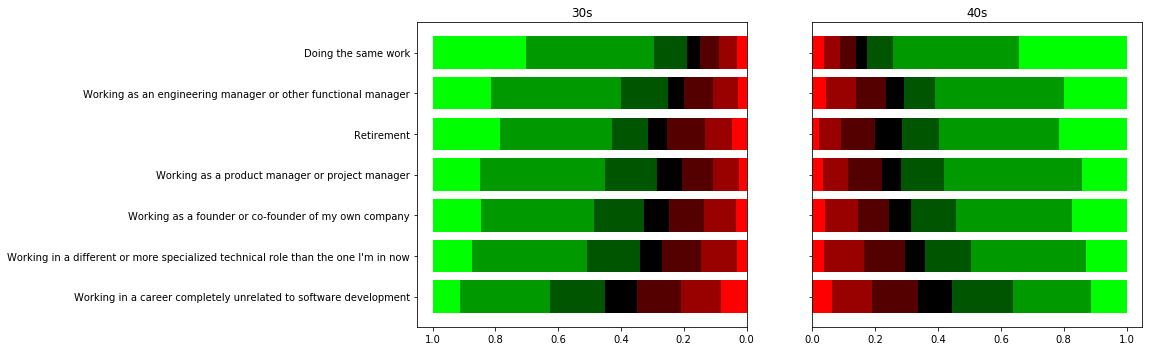

OpenSource


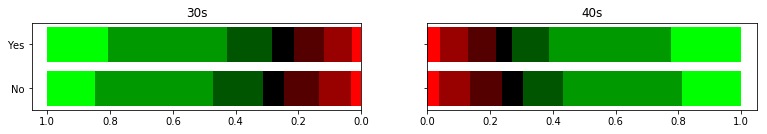

Country


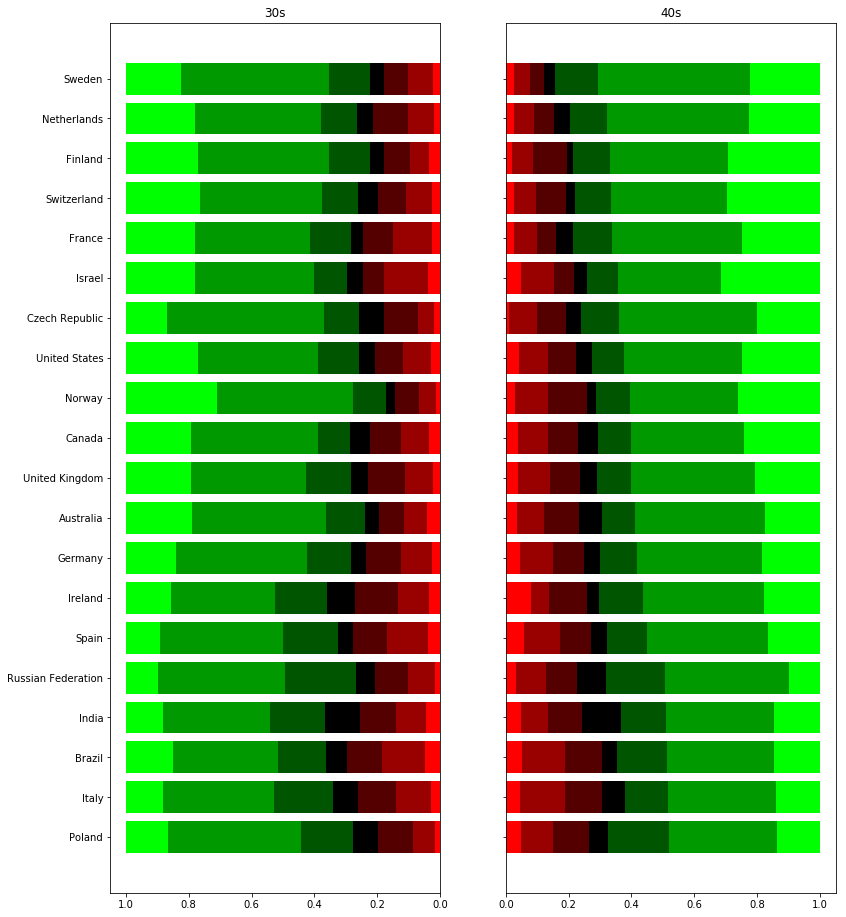

Methodology


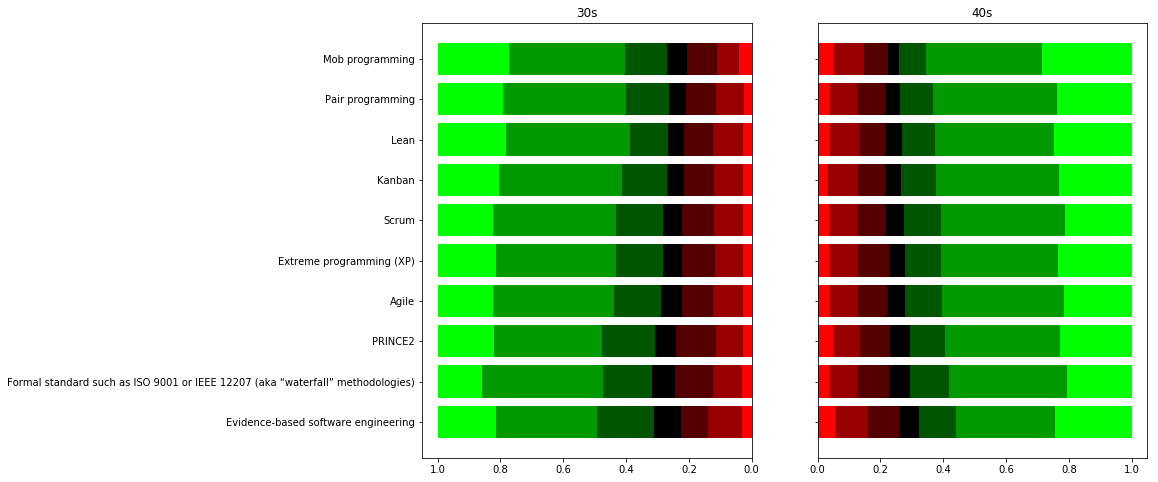

CommunicationTools


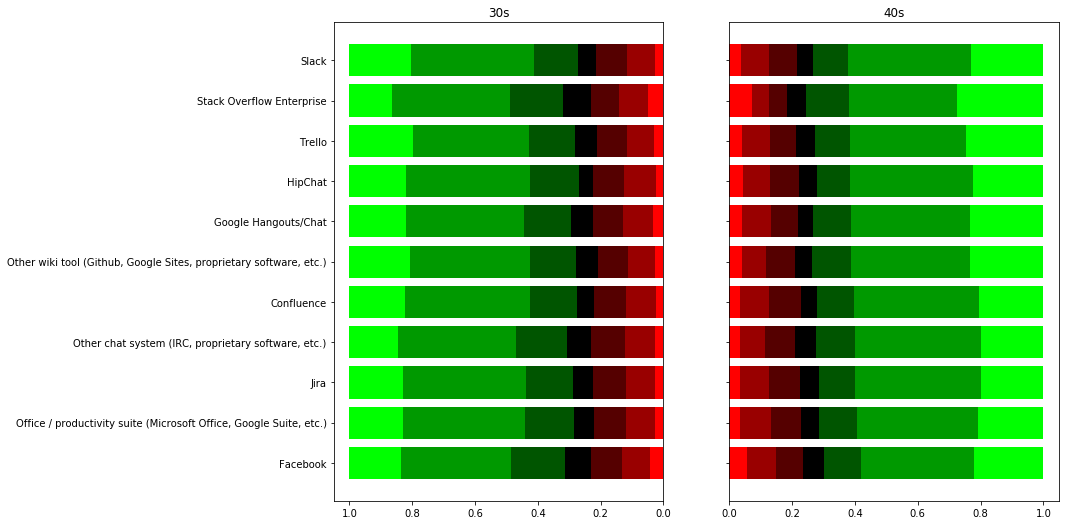

LanguageDesireNextYear


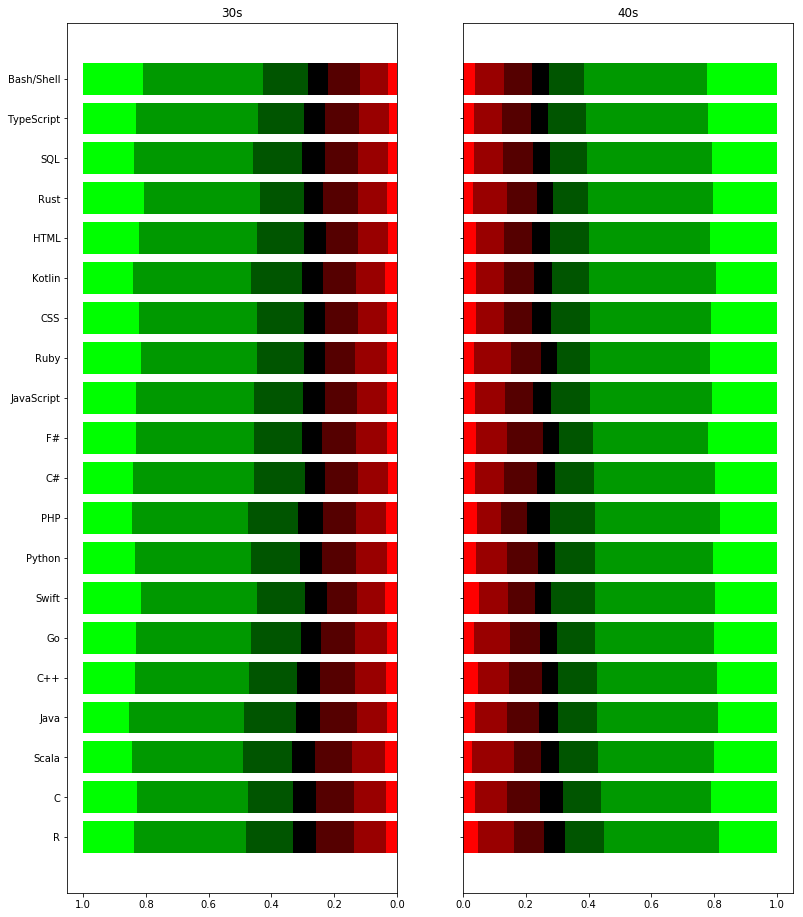

LanguageWorkedWith


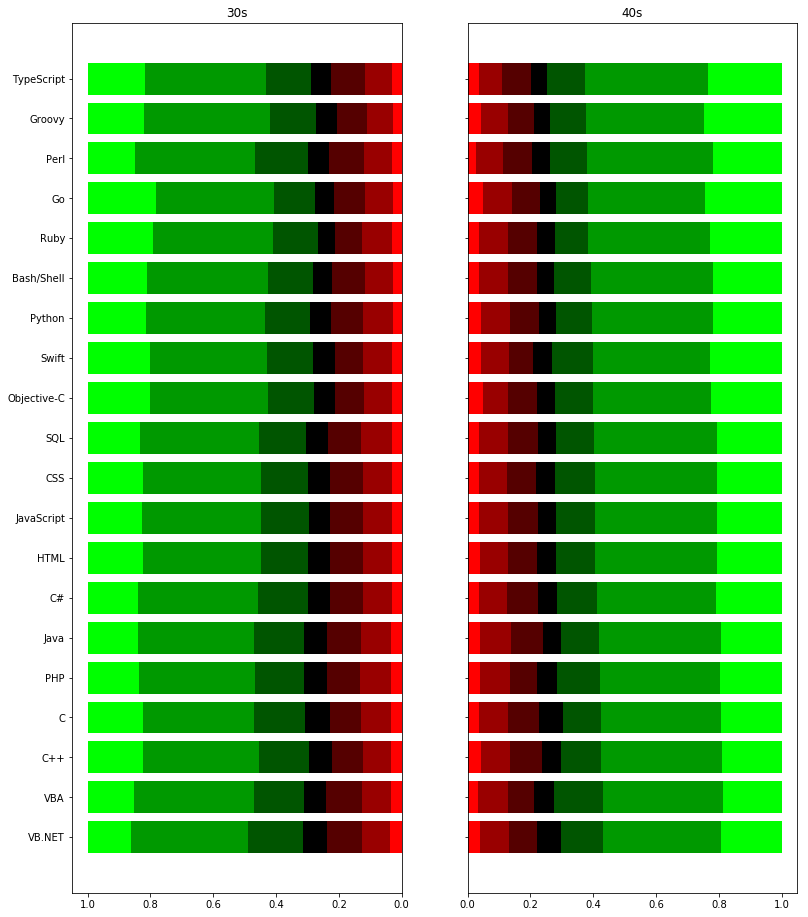

IDE


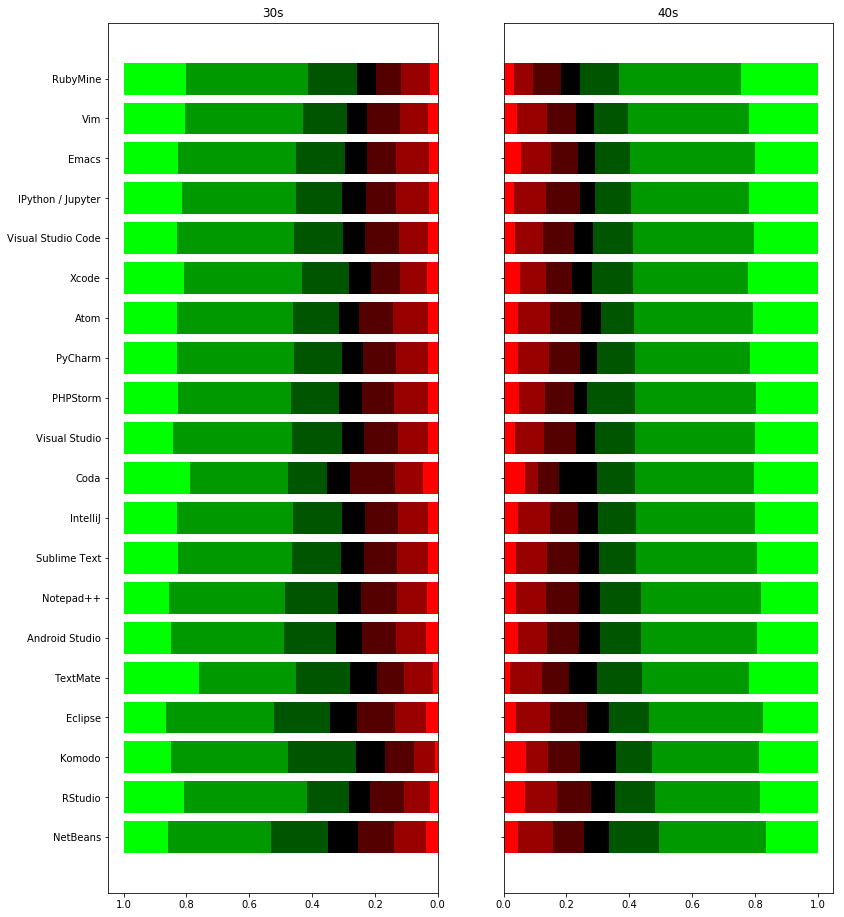

DevType


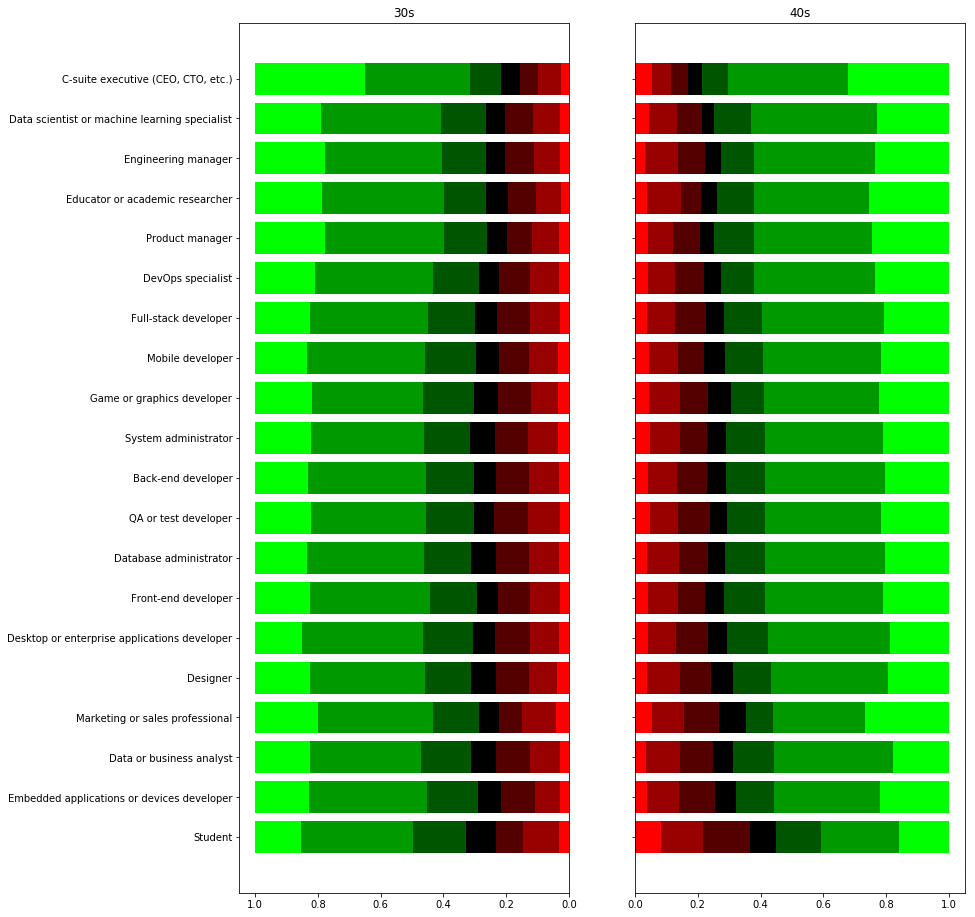

SelfTaughtTypes


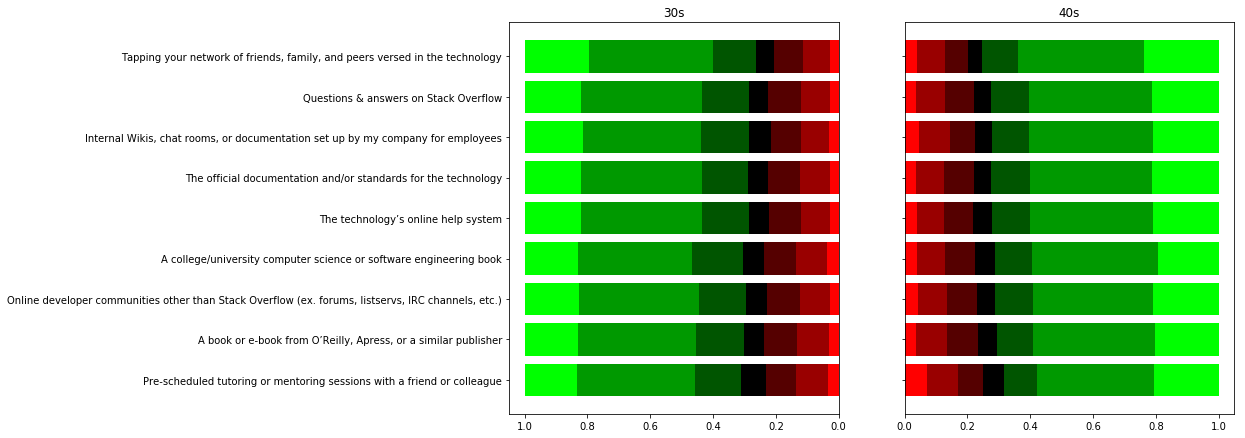

EducationTypes


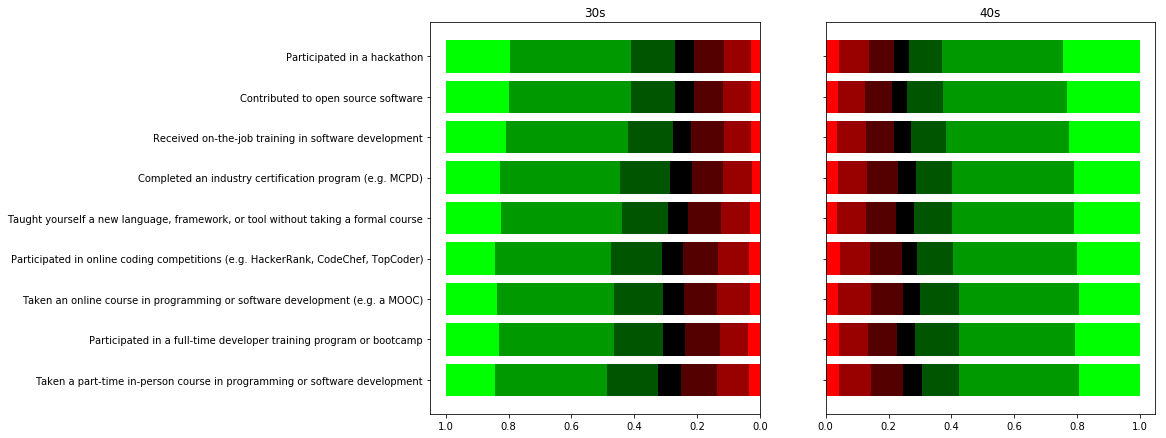

ConvertedSalary


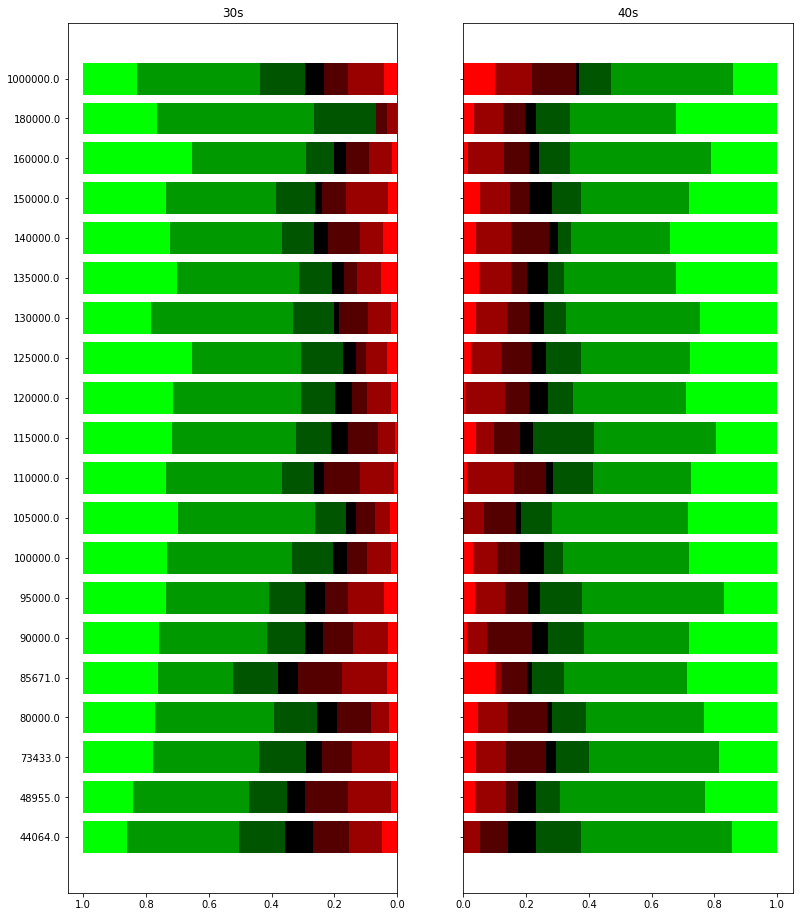

CompanySize


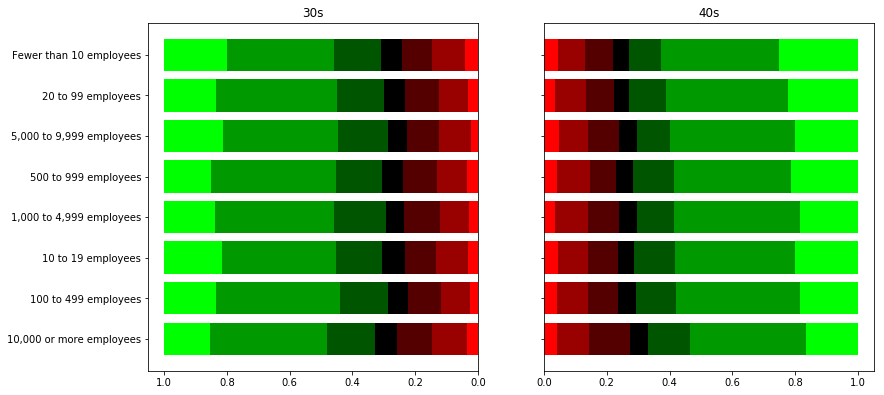

In [66]:
# constants
SATISFACTIONS = ['Extremely satisfied', 'Moderately satisfied',  'Slightly satisfied', 
              'Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Moderately dissatisfied',  
              'Extremely dissatisfied']
COLORS = ['#00ff00','#009900','#005500','#000000','#550000','#990000','#FF0000']
for column in [ 'HopeFiveYears', 'OpenSource', 'Country', 'Methodology', 'CommunicationTools','LanguageDesireNextYear', 
               'LanguageWorkedWith', 'IDE', 'DevType', 'SelfTaughtTypes', 'EducationTypes','ConvertedSalary','CompanySize']:
    print ( column)
    
    # get values
    V1 = []
    V2 = []
    T1 = {}
    T2 = {}
    for satisfaction in SATISFACTIONS:
        dfsum1 = df30[df30['JobSatisfaction'] == satisfaction][column].value_counts() / df30.shape[0]
        dfsum2 = df40[df40['JobSatisfaction'] == satisfaction][column].value_counts() / df40.shape[0]
        values1 = demultiplechoice(dfsum1, norm = False)
        values2 = demultiplechoice(dfsum2, norm = False)
        for key, val in values1:
            T1[key] = T1.get(key, 0) + float(val)
        for key, val in values2:
            T2[key] = T2.get(key, 0) + float(val)
        V1.append(values1)
        V2.append(values2)
        
    # get sums of top-3
    S = {}    
    for i in range(2):
        for key, val in V2[i]:
            S[key] = S.get(key,0)+val        
              
    # get keys
    values2 = sorted([(float(T2[key]), key) for key in T2])
    values2 = sorted([(float(S.get(key,0)/T2[key]), key) for _,key in sorted(values2)[-20:]])
    keys = [i[1] for i in values2[-20:]]
    
    if column in ['ConvertedSalary']:
        keys = [i[1] for i in sorted([(float(k),k) for k in keys])]
        
    # plot
    offset1 = dict(T1)
    offset2 = dict(T2)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    fig.set_size_inches((13,0.8*len(keys)))
    ax1.invert_xaxis()        
    for i, (satisfaction, color) in enumerate(zip(SATISFACTIONS, COLORS)):
        values1 = [offset1.get(key,0)/T1.get(key,1) for key in keys]
        values2 = [offset2.get(key,0)/T2.get(key,1) for key in keys]
        ax1.barh(keys, values1, color = color)
        ax2.barh(keys, values2, color = color)
        for key, val in V1[i]:
            if key in keys:
                offset1[key] = offset1.get(key,0) - val
        for key, val in V2[i]:
            if key in keys:
                offset2[key] = offset2.get(key,0) - val
    ax1.set_title('30''s')
    ax2.set_title('40''s')
    plt.show()

HopeFiveYears


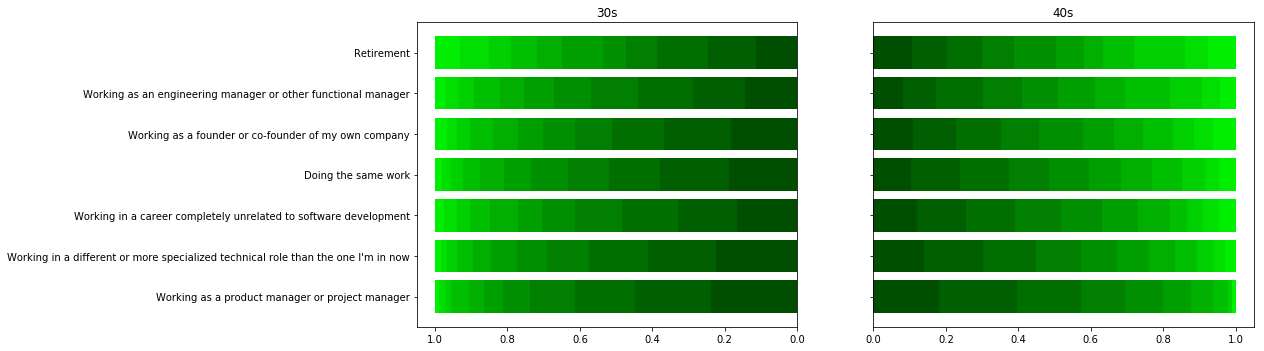

OpenSource


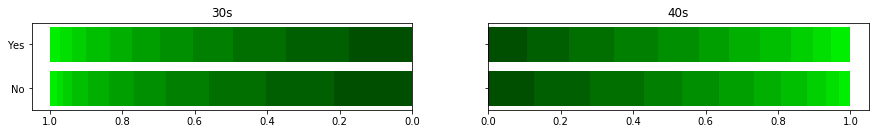

Country


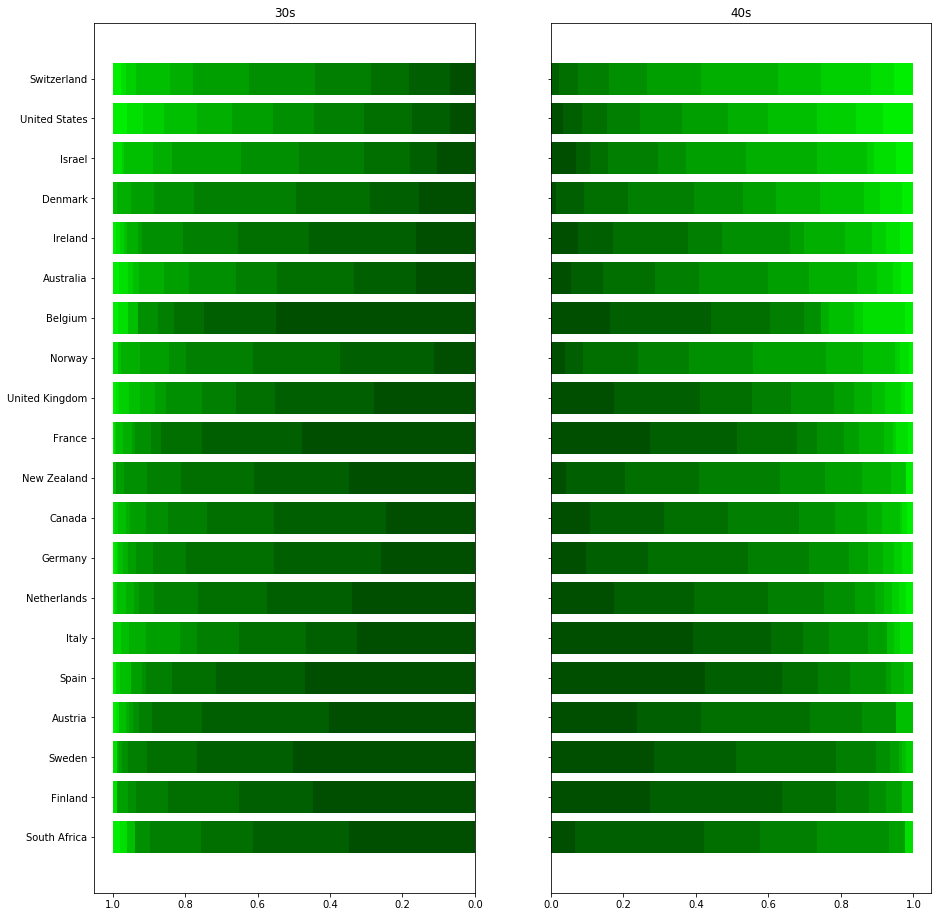

Methodology


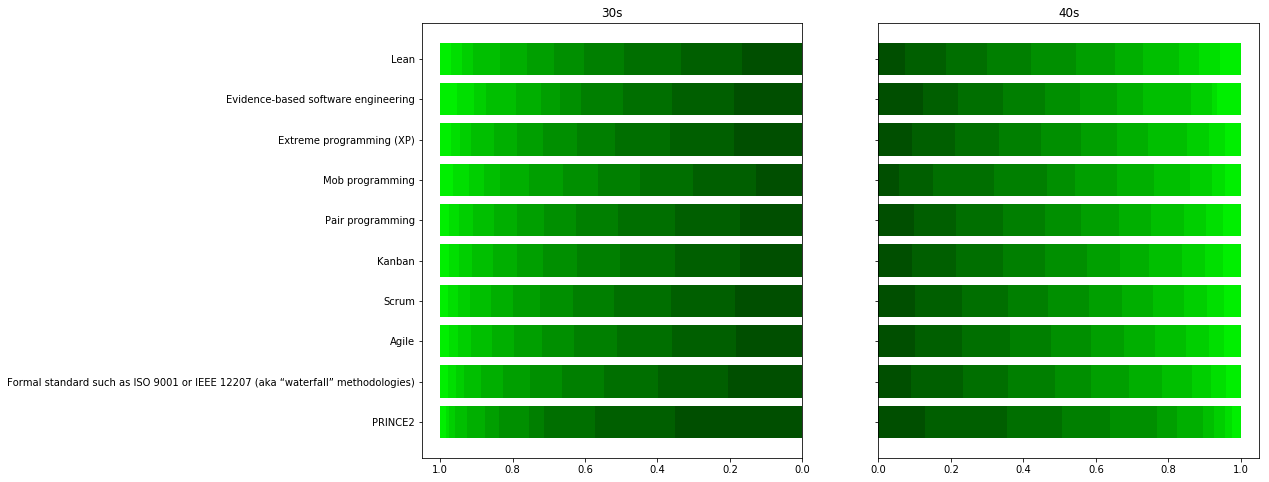

CommunicationTools


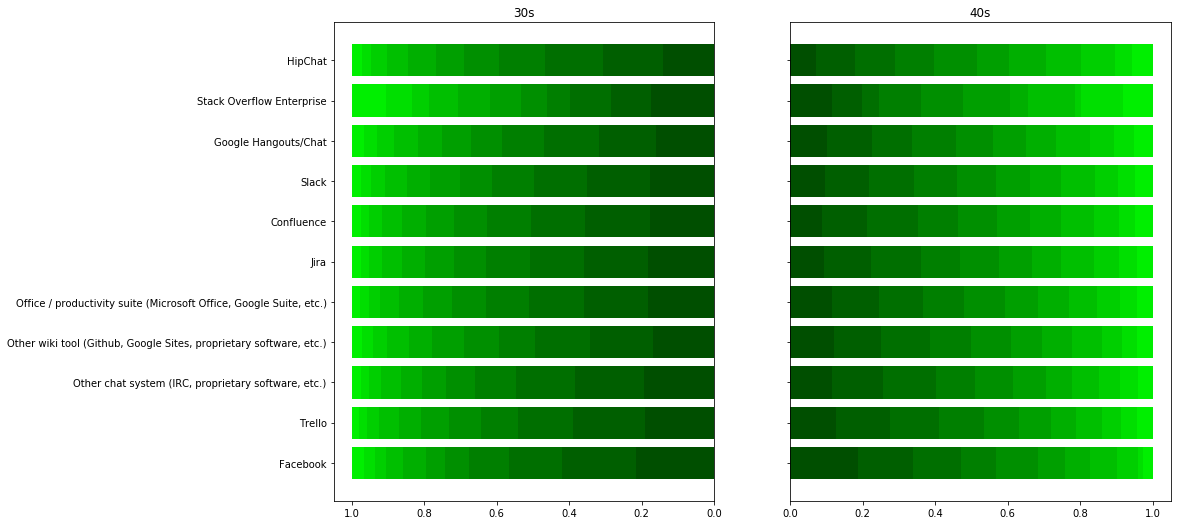

LanguageDesireNextYear


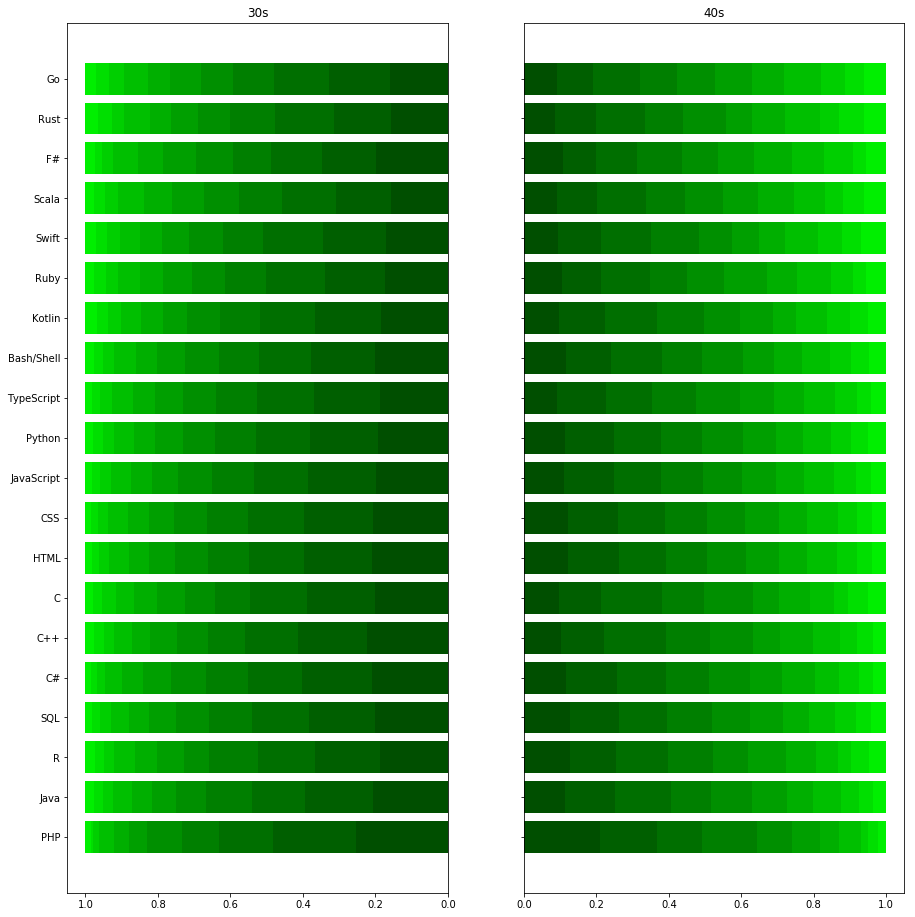

LanguageWorkedWith


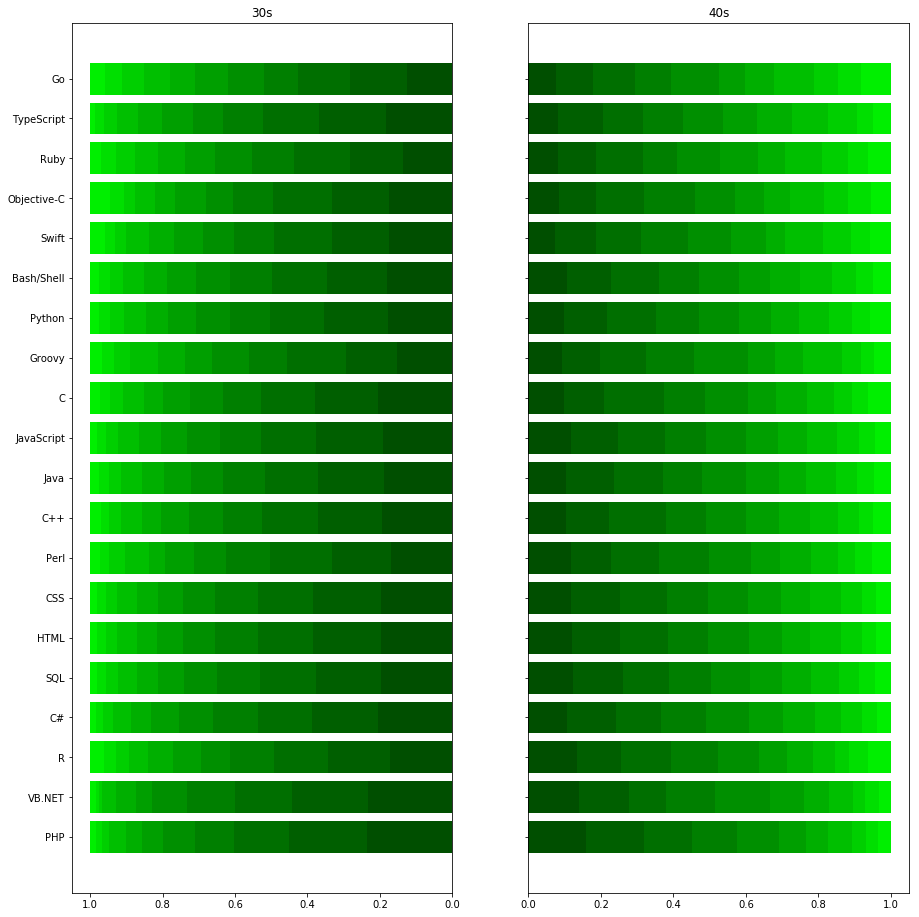

IDE


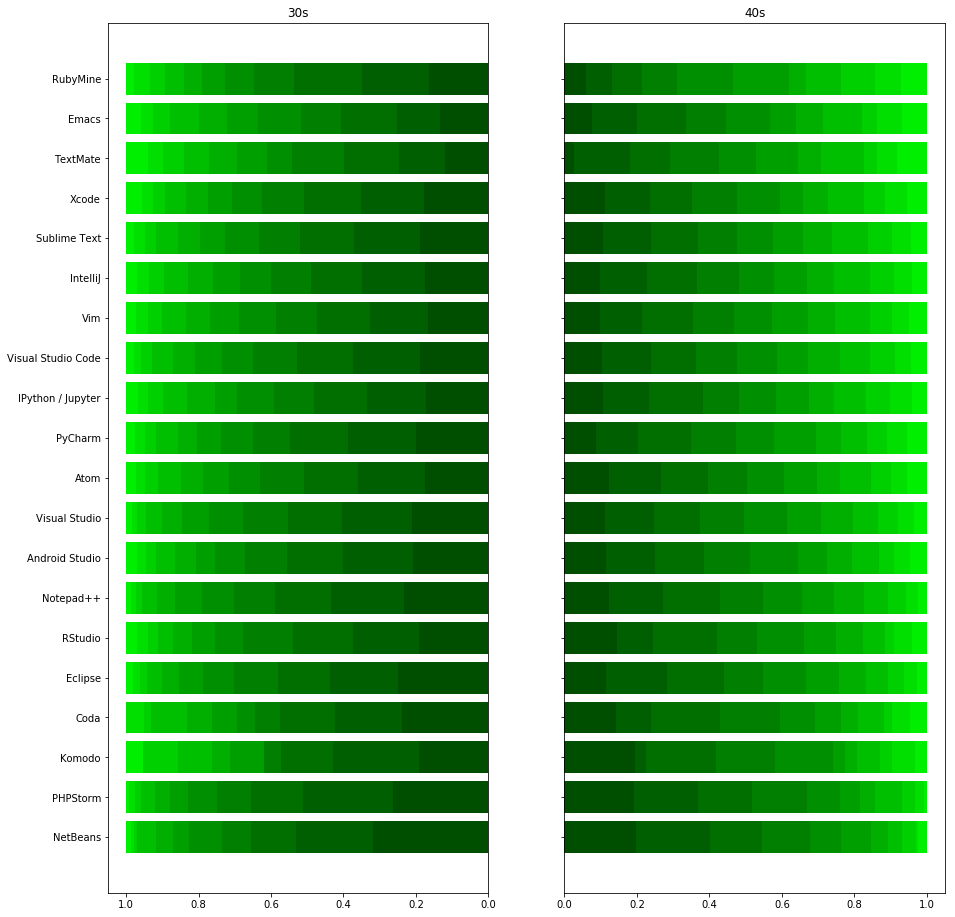

DevType


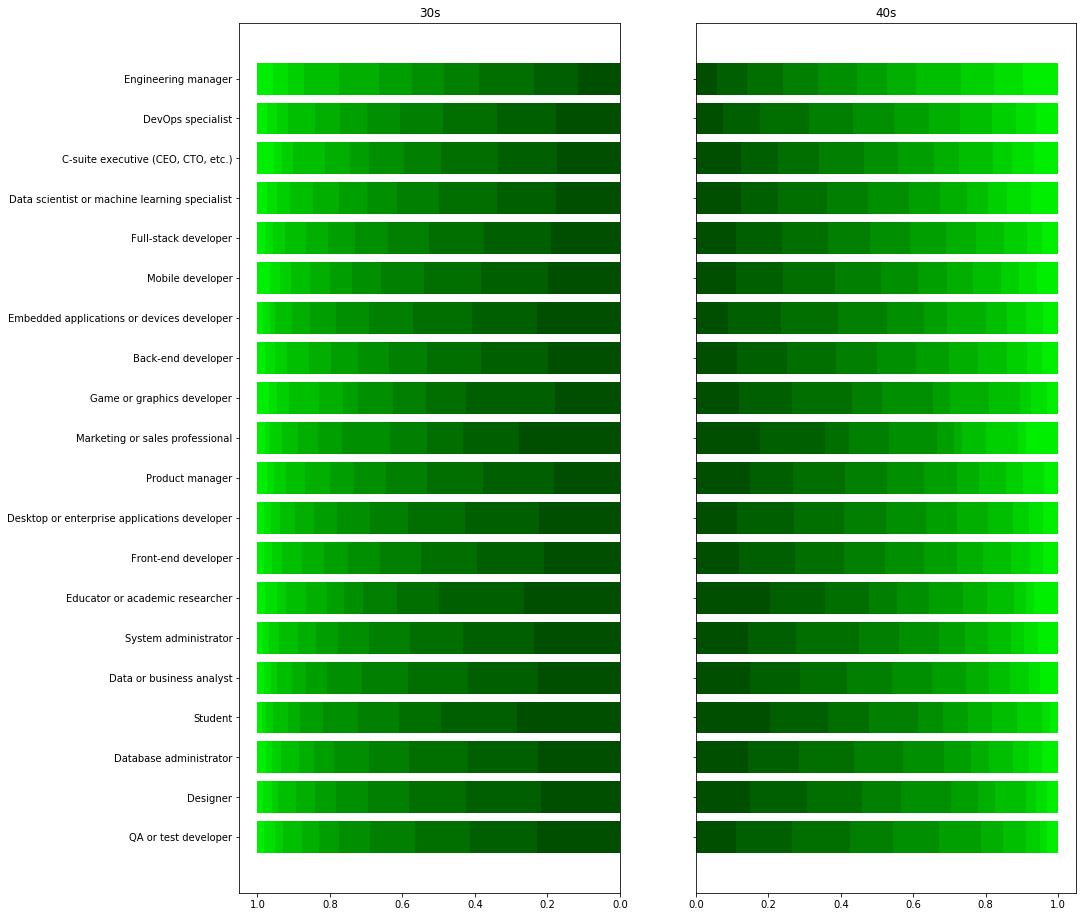

SelfTaughtTypes


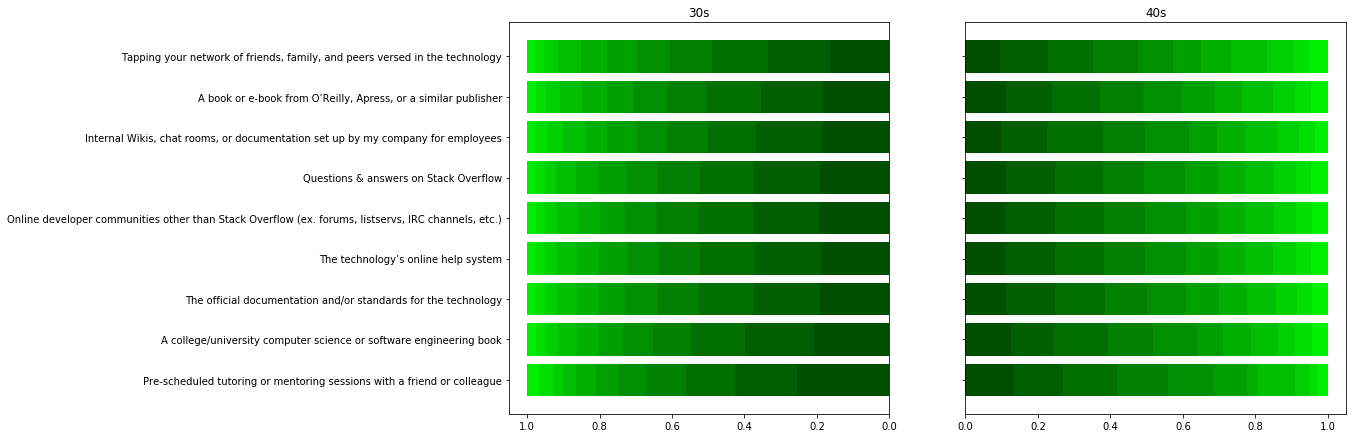

EducationTypes


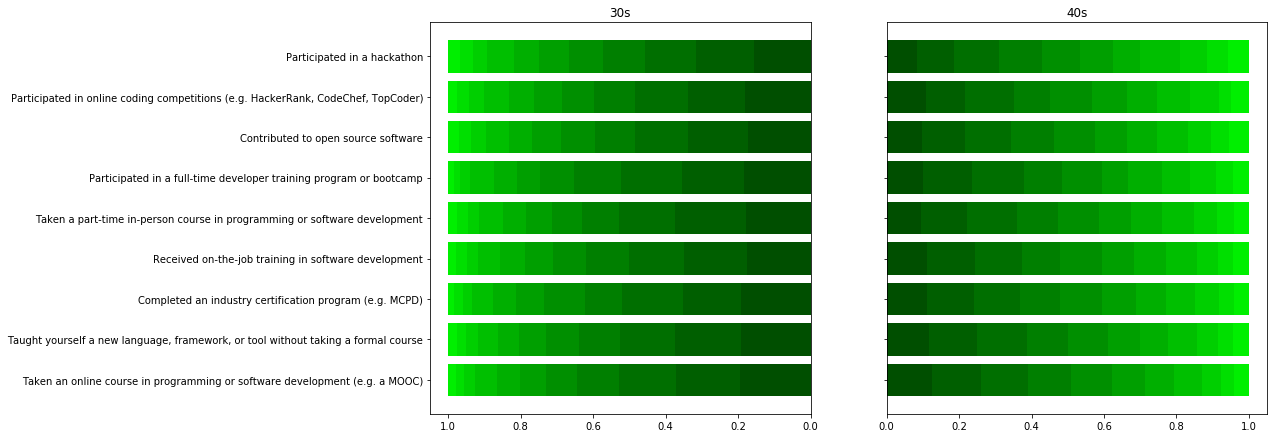

CompanySize


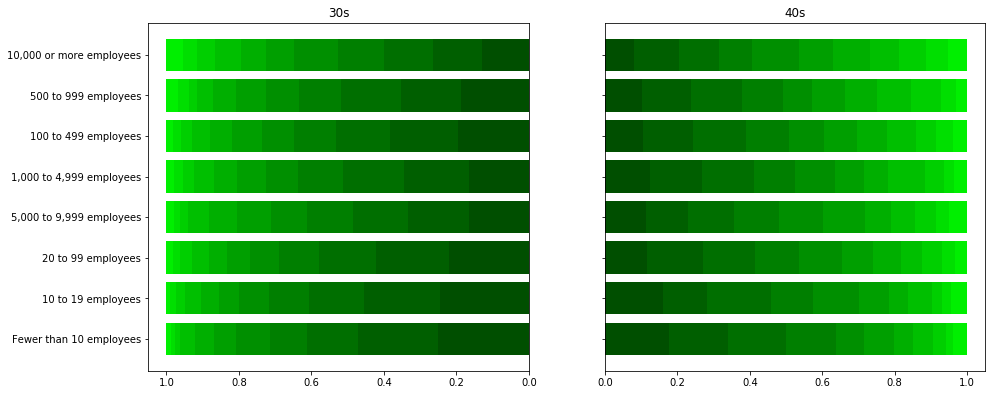

In [67]:
# constants
SALARIES = list(reversed([50000+10000*i for i in range(11)]))


for column in [ 'HopeFiveYears', 'OpenSource', 'Country', 'Methodology', 'CommunicationTools','LanguageDesireNextYear', 
               'LanguageWorkedWith', 'IDE', 'DevType', 'SelfTaughtTypes', 'EducationTypes','CompanySize']:
    print (column)
    
    # get values
    V1 = []
    V2 = []
    T1 = {}
    T2 = {}
    for salary in SALARIES:
        dfsum1 = df30[(df30['ConvertedSalary'] >= salary) & (df30['ConvertedSalary'] < salary + 10000)][column].value_counts() / df30[df30['Country'] == 'United States'].shape[0]
        dfsum2 = df40[(df40['ConvertedSalary'] >= salary) & (df40['ConvertedSalary'] < salary + 10000)][column].value_counts() / df40[df40['Country'] == 'United States'].shape[0]
        values1 = demultiplechoice(dfsum1, norm = False)
        values2 = demultiplechoice(dfsum2, norm = False)
        for key, val in values1:
            T1[key] = T1.get(key, 0) + float(val)
        for key, val in values2:
            T2[key] = T2.get(key, 0) + float(val)
        V1.append(values1)
        V2.append(values2)
        
    # get sum
    S = {}    
    for i in range(5):
        for key, val in V2[i]:
            S[key] = S.get(key,0)+val
            
    # get keys
    values2 = sorted([(float(T2[key]), key) for key in T2])
    values2 = sorted([(float(S.get(key,0)/T2[key]), key) for _, key in sorted(values2)[-20:]])
    keys = [i[1] for i in values2[-20:]]
    if column in ['Salary']:
        keys = [i[1] for i in sorted([(float(k),k) for k in keys])]
        
    # plot
    offset1 = dict(T1)
    offset2 = dict(T2)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    fig.set_size_inches((15,0.8*len(keys)))
    ax1.invert_xaxis()        
    for i, salary in enumerate(SALARIES):
        
        values1 = [offset1.get(key,0)/T1[key] for key in keys]
        values2 = [offset2.get(key,0)/T2[key] for key in keys]
        ax1.barh(keys, values1, color = '#00%01xF00' % (14-i))
        ax2.barh(keys, values2, color = '#00%01xF00' % (14-i))
        for key, val in V1[i]:
            if key in keys:
                offset1[key] = offset1.get(key,0) - val
        for key, val in V2[i]:
            if key in keys:
                offset2[key] = offset2.get(key,0) - val
    ax1.set_title('30''s')
    ax2.set_title('40''s')
    plt.show()


In [258]:
# simple calculation of mean age per country
d=df_age.groupby('Country')['Age'].mean()
for country in ['United States', 'Canada', 'United Kingdom', 'France', 'Germany', 'Netherlands']:
    print(country, d[country])

United States 33.02565089136848
Canada 31.86829268292683
United Kingdom 32.471199653529666
France 30.1500285225328
Germany 30.755174716225238
Netherlands 31.168080185042406


# Model predicting salary to evaluate features

### Data cleaning
we replaced n/a values with column mean and dealt with categorical variables by building multivalued dummies

In [425]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns
    5. For each numeric variable, fill the column with the mean value.
    6. Create dummy columns for all the categorical variables, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['ConvertedSalary'], axis=0)
    y = df['ConvertedSalary']
    
    #Drop respondent and expected salary columns
    df = df.drop(['Respondent', 'ConvertedSalary', 'Salary'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
                
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column  
        dfsum = df[var].value_counts() 
        values = [i[0] for i in demultiplechoice(dfsum, norm = False)]        
        dummies = [df[var].apply(lambda x: ';'+value+';' in ';'+x+';' if type(x) == 'str' else value == x).rename(var+'_'+str(value)) for value in values]
        df = pd.concat([df.drop(var, axis=1)] + dummies, axis=1)
    
    X = df
    return X, y


In [426]:
X_unscaled, y = clean_data(df40[df40.Country == 'United States'])
X_unscaled.head()

,YearsCoding,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,...,MilitaryUS_Yes,MilitaryUS_No,SurveyTooLong_The survey was too short,SurveyTooLong_The survey was too long,SurveyTooLong_The survey was an appropriate length,SurveyEasy_Very difficult,SurveyEasy_Somewhat difficult,SurveyEasy_Neither easy nor difficult,SurveyEasy_Somewhat easy,SurveyEasy_Very easy
76517,16,10.0,8.0,9.0,6.0,1.0,2.0,3.0,4.0,5.0,...,False,True,False,False,True,False,False,False,False,True
46947,19,10.0,8.0,1.0,2.0,3.0,7.0,4.0,5.0,9.0,...,False,True,False,True,False,False,False,True,False,False
46995,19,6.0,10.0,3.0,1.0,2.0,5.0,4.0,8.0,7.0,...,False,True,False,False,True,False,False,False,True,False
27641,22,10.0,8.0,2.0,9.0,3.0,1.0,4.0,6.0,7.0,...,False,True,False,True,False,False,False,False,True,False
12556,13,9.0,6.0,5.0,4.0,2.0,8.0,1.0,7.0,10.0,...,False,True,False,False,True,False,False,False,False,True


In [427]:
y.head()

76517    101920.0
46947    138000.0
46995    144000.0
27641    110000.0
12556    103500.0
Name: ConvertedSalary, dtype: float64

### Feature normalizing
we normalize the data by mean and standard deviation

In [428]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_unscaled) 

### Random forests to calculate feature importance
Random forest model used for its feature_importance_ member

In [429]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

model = RandomForestRegressor(n_jobs=4 )
model.fit(X_train, y_train) 
y_pred = model.predict(X_train)
print('Train r2:',r2_score(y_train, y_pred))
y_pred = model.predict(X_test)
print('Test r2:',r2_score(y_test, y_pred))

Train r2: 0.9034008113620566
Test r2: 0.5593161357676883


### Linear regression at different number of features
We used different number of features to see where the model starts to overfit

Features: 30
r2_score train: 0.4585257433206118
r2_score test: 0.39760443243877586
Features: 31
r2_score train: 0.458529778846977
r2_score test: 0.3974724567652257
Features: 32
r2_score train: 0.4597423075032928
r2_score test: 0.39896621969066537
Features: 33
r2_score train: 0.4602134923833845
r2_score test: 0.40034414220204084
Features: 34
r2_score train: 0.4603286761665445
r2_score test: 0.39951149369349637
Features: 35
r2_score train: 0.46049165120928326
r2_score test: 0.39991789604055816
Features: 36
r2_score train: 0.46253590975653525
r2_score test: 0.3981975729692234
Features: 37
r2_score train: 0.46253751130831267
r2_score test: 0.39833371660029604
Features: 38
r2_score train: 0.4638213581851762
r2_score test: 0.396157038037075
Features: 39
r2_score train: 0.46385986150853253
r2_score test: 0.3966535758252522
Features: 40
r2_score train: 0.46696624720947055
r2_score test: 0.4027745769010266
Features: 41
r2_score train: 0.46697095339621675
r2_score test: 0.4027894284837408
Featur

r2_score train: 0.5081467790168703
r2_score test: 0.3650433257843365
Features: 130
r2_score train: 0.5088993051234116
r2_score test: 0.36604179842691265
Features: 131
r2_score train: 0.508780852515365
r2_score test: 0.36641348167774945
Features: 132
r2_score train: 0.5081253736625623
r2_score test: 0.3655786514206608
Features: 133
r2_score train: 0.5091893704470432
r2_score test: 0.36841596116760944
Features: 134
r2_score train: 0.5086904920329722
r2_score test: 0.36592640314112657
Features: 135
r2_score train: 0.5088762338963098
r2_score test: 0.3599927628345816
Features: 136
r2_score train: 0.508387639991456
r2_score test: 0.36499215153701403
Features: 137
r2_score train: 0.509840393140008
r2_score test: 0.36568171575784947
Features: 138
r2_score train: 0.5100820053764598
r2_score test: 0.3660474921281405
Features: 139
r2_score train: 0.5071806849236222
r2_score test: 0.3604605321869965
Features: 140
r2_score train: 0.5105482223877743
r2_score test: 0.369381874690519
Features: 141
r2

r2_score train: 0.5278694680663873
r2_score test: 0.33304872585421896
Features: 230
r2_score train: 0.5292718372391894
r2_score test: 0.32856557922003937
Features: 231
r2_score train: 0.5307318703775964
r2_score test: 0.32770990760496665
Features: 232
r2_score train: 0.5318690493342354
r2_score test: 0.3284838122120177
Features: 233
r2_score train: 0.5314932027226554
r2_score test: 0.3268161895693077
Features: 234
r2_score train: 0.5281992069648194
r2_score test: 0.33133802707954274
Features: 235
r2_score train: 0.5303595435371661
r2_score test: 0.32324536477663657
Features: 236
r2_score train: 0.5317352109946444
r2_score test: 0.3257787788564205
Features: 237
r2_score train: 0.5234182694844725
r2_score test: 0.33034822734277536
Features: 238
r2_score train: 0.5324435358130302
r2_score test: 0.3253675608410872
Features: 239
r2_score train: 0.5331978683210593
r2_score test: 0.32472092371835903
Features: 240
r2_score train: 0.5335302116339565
r2_score test: 0.32453577291992064
Features: 

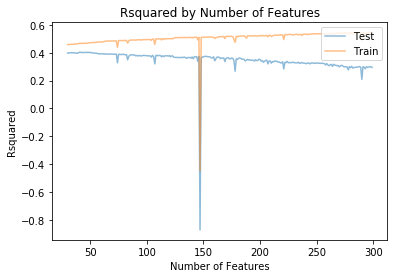

In [430]:
cutoffs = range(30,300)
feature_count = []
r2_train = []
r2_test = []
for cutoff in cutoffs:
    num_of_features = cutoff
    print('Features:',num_of_features)
    X_cutoff = X[:,model.feature_importances_.argsort()[-num_of_features:]]
    X_train, X_test, y_train, y_test = train_test_split(X_cutoff, y, test_size = .30, random_state=42)
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    feature_count.append(num_of_features)
    y_pred = lm_model.predict(X_train)
    score = r2_score(y_train, y_pred)
    r2_train.append(score)
    print('r2_score train:', score)
    y_pred = lm_model.predict(X_test)
    score = r2_score(y_test, y_pred)
    r2_test.append(score)
    print('r2_score test:', score)
plt.plot(feature_count, r2_test, label="Test", alpha=.5)
plt.plot(feature_count, r2_train, label="Train", alpha=.5)
plt.xlabel('Number of Features')
plt.ylabel('Rsquared')
plt.title('Rsquared by Number of Features')
plt.legend(loc=1)
plt.show()    


### Use the linear regression model with 49 features

In [431]:
num_of_features = 49
print('Features:',num_of_features)
X_cutoff = X[:,model.feature_importances_.argsort()[-num_of_features:]]
X_train, X_test, y_train, y_test = train_test_split(X_cutoff, y, test_size = .30, random_state=42)
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
    
feature_count.append(num_of_features)
y_pred = lm_model.predict(X_train)
score = r2_score(y_train, y_pred)
r2_train.append(score)
print('r2_score train:', score)
y_pred = lm_model.predict(X_test)
score = r2_score(y_test, y_pred)
r2_test.append(score)
print('r2_score test:', score)

Features: 49
r2_score train: 0.4710850221902869
r2_score test: 0.40303320050410973


### Order and show coefficients

In [433]:
def coef_weights(coefficients, columns):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_unscaled.columns[model.feature_importances_.argsort()[-49:]])

#A quick look at the top results
coef_df.head(10)

,est_int,coefs,abs_coefs
48,SalaryType_Monthly,134080.331923,134080.331923
47,SalaryType_Weekly,125661.143590,125661.143590
46,Employment_Employed full-time,40009.882616,40009.882616
9,YearsCoding,16438.674003,16438.674003
0,Exercise_I don't typically exercise,-14488.197101,14488.197101
34,JobEmailPriorities5,-11579.529830,11579.529830
44,AssessJob9,10863.730901,10863.730901
13,FrameworkWorkedWith_TensorFlow,10833.903640,10833.903640
41,AdsPriorities2,10554.764523,10554.764523
36,CareerSatisfaction_Extremely satisfied,9834.053947,9834.053947


In [442]:
list(df_schema[df_schema.Column == 'AdsPriorities2']['QuestionText'])[0]

'Please rank the following advertising qualities in order of their importance to you (by dragging the choices up and down), where 1 is the most important, and 7 is the least important. The advertisement is honest about its goals'